# 1 Correção atmosférica

Código para correção de efeitos atmosféricos segundo 
CHAVEZ Jr., P.S. An improved dark-object subtraction technique for 
scattering correction of multispectral data. Remote Sensing of Environment,
New York, v.24, p.459-479, 1988.

In [ ]:
print("*********************************************************************");
print('****        Código criado pelo Prof. Dr. Thiago Statella         ****');
print('****        Disciplina: Processamento Digital de Imagens         ****');
print('****  Instituto Federal de Educação, Ciência e Tecnologia de MT  ****');
print('*********************************************************************');
print(' ');
print(' ');

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np # as imagens são lidas como numpy arrays
from matplotlib import pyplot as plt # é preciso chamar os submódulos
from skimage import io, filters
from skimage.exposure import histogram
import datetime

In [2]:
#Leitura da imagem
Name  = input('Informe o nome da imagem (banda azul): ')
print(f"Nome da imagem: {Name}"); 

Nome da imagem: Banda_ETM+1.tif


In [3]:
L     = int(input('Landsat-5 ou Landsat-7? '))

if L == 7:
    Ganho = input('Ganho baixo (1) ou alto (2)? ')

print(f"Landsat - {L}")
print(f"Ganho: {Ganho}")

Landsat - 7
Ganho: 1


In [4]:
Data  = input('Informe a data de aquisição da imagem (YYYY-MM-DD): ')
#Transformando em um número para poder comparar diferentes datas
print(f"Data: {Data}")

Data: 1986-12-12


In [5]:
#obtenha a data em dias julianos a partir da string:
Data_img = datetime.datetime.strptime(Data, "%Y-%m-%d").strftime('%j')
Data_img = float(Data_img)
#my_date = datetime.strptime(Data, "%Y-%m-%d")
#Data    = datetime.timestamp(my_date)
print(f"Dia do ano: {Data_img}")

Dia do ano: 346.0


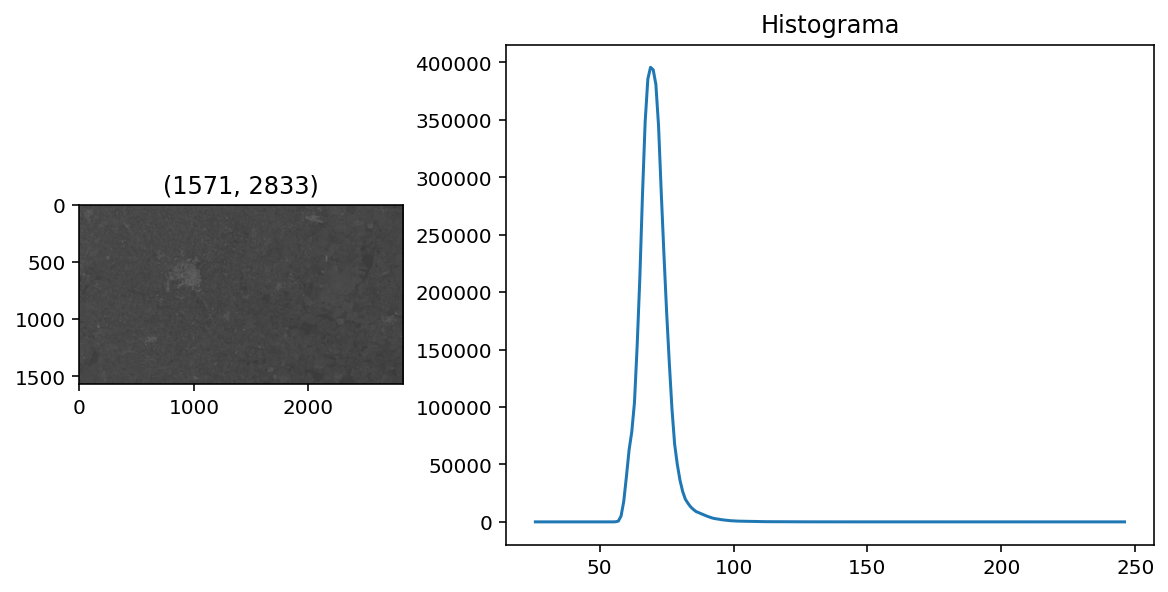

In [6]:
Get0  = io.imread(Name); #Leitura da imagem
hist, hist_centers = histogram(Get0)# histograma da imagem. hist_centers são os centros dos bins.
#Para imagens do tioi int, cada tom de cinza é seu próprio bin.

fig, ax = plt.subplots(ncols=2, figsize=(8, 4),
                        gridspec_kw={'width_ratios':[1,2]},
                        constrained_layout=True); 
ax[0].imshow(Get0, vmin=0, vmax=255, cmap='gray')
ax[0].set_title(Get0.shape); 
#ax[0].axis('off')

ax[1].plot(hist_centers, hist)
ax[1].set_title('Histograma'); 

In [7]:
NDmin = input('Insira o valor do pixel com bruma'); 
NDmin = int(NDmin)

In [8]:
#Testando para identificar o modelo de espalhamento atmosférico
if NDmin < 56:
   Power = -4
   Mod = 'Muito limpa'
if NDmin >= 56 and NDmin < 75:
   Power = -2
   Mod = 'Limpa'
if NDmin >= 75 and NDmin < 95:
   Power = -1
   Mod = 'Moderada'
if NDmin >= 95 and NDmin < 115:
   Power = -0.7
   Mod = 'Com bruma'
if NDmin >= 115:
   Power = -0.5
   Mod = 'Com muita bruma'

print(f"A potência do Modelo de Espalhamento (Lambda^Power) identificada foi: {Power}")
print(f"O modelo adotado é: {Mod}")

A potência do Modelo de Espalhamento (Lambda^Power) identificada foi: -4
O modelo adotado é: Muito limpa


In [9]:
#Valores médios de comprimento de onda para as bandas do Landsat 5/7
MeanLambda_Azul     = 0.485
MeanLambda_Verde    = 0.560
MeanLambda_Vermelho = 0.660
MeanLambda_IVP      = 0.830
MeanLambda_IVM1     = 1.650
MeanLambda_IVM2     = 2.215

In [10]:
"""Função específica de espalhamento atmosférico para cada uma das bandas de acordo
com o modelo de atmosférico estabelecido a partir do ND escuro lido na banda
do Azul"""

MOD_Esp_Azul     = MeanLambda_Azul**Power
MOD_Esp_Verde    = MeanLambda_Verde**Power
MOD_Esp_Vermelho = MeanLambda_Vermelho**Power
MOD_Esp_IVP      = MeanLambda_IVP**Power
MOD_Esp_IVM1     = MeanLambda_IVM1**Power
MOD_Esp_IVM2     = MeanLambda_IVM2**Power

In [11]:
"""% Estimando valores de ND com reflectância mínima para as demais bandas,a
% partir do valor ND identificado na banda do Azul
% Os dados abaixo são factores de multiplicação que serão usados para predizer
% valores de bruma nas bandas 2 a 7. Eles são calculados usando o modelo 
% específico de espalhamento para a banda Azul como normalizador"""

Factor_Predict_Azul     = MOD_Esp_Azul / MOD_Esp_Azul
Factor_Predict_Verde    = MOD_Esp_Verde / MOD_Esp_Azul
Factor_Predict_Vermelho = MOD_Esp_Vermelho / MOD_Esp_Azul
Factor_Predict_IVP      = MOD_Esp_IVP / MOD_Esp_Azul
Factor_Predict_IVM1     = MOD_Esp_IVM1 / MOD_Esp_Azul
Factor_Predict_IVM2     = MOD_Esp_IVM2 / MOD_Esp_Azul

Os valores acima ainda são fatores de multiplicação para prever os valores ND com bruma.
Precisamos considerar as variações de ganho e offset de cada banda.
Isso pode ser resolvido gerando fatores de ganho normalizados. 
Estes valores são então aplicados aos NDs de bruma que serão preditos juntamente com os respectivos offsets para encontrar os valores verdadeiros de bruma para cada banda.

Os NDs da imagem podem ser estimados por meio de 
```
ND = Gain * L + Offset 
```
em que L é a radiância. 
Temos que: 
```
L = {[(Lmax - Lmin) / 255] * ND} + Lmin
```
Portanto: 
```
ND = [(L - Lmin) * 255] / (Lmax - Lmin)
```
Fazendo 
```
G = 255 / (Lmax - Lmin) e Offset = (-255 * Lmin) / (Lmax - Lmin)
```
Podemos escrever: 
```
ND = G * L + Offset
```

Para o landsat - 5

In [12]:
# NOTE: OS VALORES DE CALIBRAÇÃO SÃO DA BANDA 1 À 7, INCLUINDO A BANDA 6 DO TERMAL
 #Parâmetros de calibração para o TM5 antes de 04/05/2003 em W/m^2.sr.um
 #Parâmetros de calibração para o TM5 depois de 04/05/2003 em W/m^2.sr.um
 #Data_img = dt.datetime.strptime(Data, "%Y-%m-%d").strftime('%j')
#Data_img = float(Data_img)
if L == 5:
    #Data04052003  = datetime.timestamp(datetime.strptime('2003-05-04', "%Y-%m-%d"))
    Data04052003 = datetime.datetime.strptime('2003-05-04', "%Y-%m-%d").strftime('%j')
    if Data_img <= float(Data04052003):
        Lmin = np.array([-1.52, -2.84, -1.17, -1.51, -0.37, 1.2378, -0.15])
        Lmax = np.array([152.1, 296.81, 204.3, 206.2, 27.19, 15.303, 14.38])
    else:
        Lmin = np.array([-1.52, -2.84, -1.17, -1.51, -0.37, 1.2378, -0.15])
        Lmax = np.array([193, 365, 264, 221, 30.2, 15.303, 16.5])

Para o Landsat - 7

In [14]:
#NOTE: OS VALORES DE CALIBRAÇÃO SÃO DA BANDA 1 À 7, INCLUINDO A BANDA 6 DO TERMAL
#%Parâmetros de calibração para o ETM+ antes de 01/07/2000 em W/m^2.sr.um
#Ganho baixo (1) e alto (2)
if L == 7 and int(Ganho) == 1:
    #Data01072000  = datetime.timestamp(datetime.strptime('2000-07-01', "%Y-%m-%d"))
    Data01072000 = datetime.datetime.strptime('2000-07-01', "%Y-%m-%d").strftime('%j')
    if Data_img <= float(Data01072000):
        Lmin = np.array([-6.2, -6, -4.5, -4.5, -1, 0, -0.35])
        Lmax = np.array([297.5, 303.4, 235.5, 235, 47.7, 17.04, 16.6])
    else:
        Lmin = np.array([-6.2, -6.4, -5, -5.1, -1, 0.0, -0.35])
        Lmax = np.array([293.7, 300.9, 234.4, 241.1, 47.57, 17.04, 16.54])

if L == 7 and int(Ganho) == 2:
    #Data01072000  = datetime.timestamp(datetime.strptime('2000-07-01', "%Y-%m-%d"))
    Data01072000 = datetime.datetime.strptime('2000-07-01', "%Y-%m-%d").strftime('%j')
    if Data_img <= float(Data01072000):
        Lmin = np.array([-6.2, -6, -4.5, -4.5, -1, 3.2, -0.35])
        Lmax = np.array([194.3, 202.4, 158.6, 157.5, 31.76, 12.65, 10.932])
    else:
        Lmin = np.array([-6.2, -6.4, -5, -5.1, -1, 3.2, -0.35])
        Lmax = np.array([191.6, 196.5, 152.9, 157.4, 31.06, 12.65, 10.8])

In [15]:
"""%Calculando o Ganho e offset
%Fazendo Gain = 255 / (Lmax - Lmin) e Offset = (-255 * Lmin) / (Lmax - Lmin)
%Podemos escrever: ND = Gain * L + Offset"""

Gain_Azul       = 255 / (Lmax[0] - Lmin[0])
Offset_Azul     = -255 * Lmin[0] / (Lmax[0] - Lmin[0])
Gain_Verde      = 255 / (Lmax[1] - Lmin[1])
Offset_Verde    = -255 * Lmin[1] / (Lmax[1] - Lmin[1])
Gain_Vermelho   = 255 / (Lmax[2] - Lmin[2])
Offset_Vermelho = -255 * Lmin[2] / (Lmax[2] - Lmin[2])
Gain_IVP        = 255 / (Lmax[3] - Lmin[3])
Offset_IVP      = -255 * Lmin[3]/ (Lmax[3] - Lmin[3])
Gain_IVM1       = 255 / (Lmax[4] - Lmin[4])
Offset_IVM1     = -255 * Lmin[4] / (Lmax[4] - Lmin[4])
Gain_IVM2       = 255 / (Lmax[6] - Lmin[6])
Offset_IVM2     = -255 * Lmin[6] / (Lmax[6] - Lmin[6])

In [16]:
"""%Estimando os fatores de ganho normalizados: Gain_Azul / Gain_Bi = 2,
%3,..., 7."""

NormalizedGain_Azul     = Gain_Azul / Gain_Azul
NormalizedGain_Verde    = Gain_Verde / Gain_Azul
NormalizedGain_Vermelho = Gain_Vermelho / Gain_Azul
NormalizedGain_IVP      = Gain_IVP / Gain_Azul
NormalizedGain_IVM1     = Gain_IVM1 / Gain_Azul
NormalizedGain_IVM2     = Gain_IVM2 / Gain_Azul

In [17]:
"""%Esta normalização juntamente com os offsets permitem transformar os
%valores de ND com bruma preditos em ND com bruma reais
% Isto é feito aplicando-se a seguinte equação
% NDhaze = NormalizedGain * ND_Predicted + Offset
% Os valores preditos para a banda 2, por exemplo, são calculados como
%ND_Predicted_2 = (NDmin - Offset_Azul) * Factor_Predict_Verde"""

ND_Predicted_Azul     = (NDmin - Offset_Azul) * Factor_Predict_Azul
ND_Predicted_Verde    = (NDmin - Offset_Azul) * Factor_Predict_Verde
ND_Predicted_Vermelho = (NDmin - Offset_Azul) * Factor_Predict_Vermelho
ND_Predicted_IVP      = (NDmin - Offset_Azul) * Factor_Predict_IVP
ND_Predicted_IVM1     = (NDmin - Offset_Azul) * Factor_Predict_IVM1
ND_Predicted_IVM2     = (NDmin - Offset_Azul) * Factor_Predict_IVM2

In [18]:
#%Finalmente, os valores de ND com bruma são obtidos por

ND_Haze_Azul     = round((NormalizedGain_Azul * ND_Predicted_Azul) + Offset_Azul)
ND_Haze_Verde    = round((NormalizedGain_Verde * ND_Predicted_Verde) + Offset_Verde)
ND_Haze_Vermelho = round((NormalizedGain_Vermelho * ND_Predicted_Vermelho) + Offset_Vermelho)
ND_Haze_IVP      = round((NormalizedGain_IVP * ND_Predicted_IVP) + Offset_IVP)
ND_Haze_IVM1     = round((NormalizedGain_IVM1 * ND_Predicted_IVM1) + Offset_IVM1)
ND_Haze_IVM2     = round((NormalizedGain_IVM2 * ND_Predicted_IVM2) + Offset_IVM2)

print(f"Espalhamento em ND na banda do Azul: {ND_Haze_Azul}")
print(f"Espalhamento em ND na banda do Verde: {ND_Haze_Verde}")
print(f"Espalhamento em ND na banda do Vermelho: {ND_Haze_Vermelho}")
print(f"Espalhamento em ND na banda do IVP: {ND_Haze_IVP}")
print(f"Espalhamento em ND na banda do IVM1: {ND_Haze_IVM1}")
print(f"Espalhamento em ND na banda do IVM2: {ND_Haze_IVM2}")
print(type(ND_Haze_Azul))

Espalhamento em ND na banda do Azul: 50.0
Espalhamento em ND na banda do Verde: 30.0
Espalhamento em ND na banda do Vermelho: 22.0
Espalhamento em ND na banda do IVP: 12.0
Espalhamento em ND na banda do IVM1: 7.0
Espalhamento em ND na banda do IVM2: 7.0
<class 'numpy.float64'>


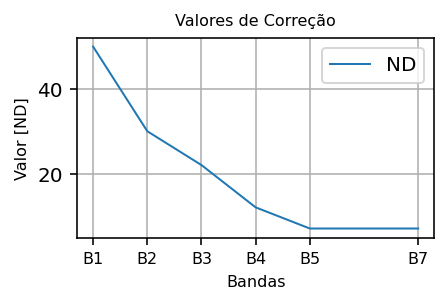

In [19]:
Val = np.array([ND_Haze_Azul, ND_Haze_Verde, ND_Haze_Vermelho, ND_Haze_IVP, ND_Haze_IVM1,ND_Haze_IVM2])
x = np.array([1, 2, 3, 4, 5, 7])

fig, ax = plt.subplots(figsize=(3,2),constrained_layout=True)
ax.plot(x,Val,label='ND',linewidth=1); 
ax.set_xticks([1,2,3,4,5,7]); 
ax.set_xticklabels(['B1', 'B2', 'B3','B4','B5','B7'],fontsize=8); 
ax.grid()
ax.legend()
ax.set_title("Valores de Correção",fontsize=8)
ax.set_ylabel("Valor [ND]",fontsize=8)
ax.set_xlabel("Bandas",fontsize=8); 

APLICAR A CORREÇÃO ÀS IMAGENS, EXIBIR IMAGENS E HISTOGRAMAS